## OilyGiant

## 1. Contenido

* [1 Contenido](#content)
* [2 Introducción](#intro)
* [3 Inicialización](#inic)
    * [3.1 Cargar Librerias](#library)
    * [3.2 Cargar Datos](#datos)
* [4 Exploración de los datos](#exp)     
* [5 Entrenamiento del modelo](#model) 
    * [5.1 Región 0](#reg0)
    * [5.2 Región 1](#reg1)
    * [5.3 Región 2](#reg2)
* [6 Preparación cálculo ganancias](#prep) 
* [7 Función cálculo ganancias](#func)
    * [7.1 Beneficios región 0](#func0)
    * [7.2 Beneficios región 1](#func1)
    * [7.3 Beneficios región 2](#func2)        
* [8 Cálculo riesgo y ganancias final](#calculo)  
    * [8.1 Riesgo y ganancias región 0](#calculo0)
    * [8.2 Riesgo y ganancias región 1](#calculo1)
    * [8.3 Riesgo y ganancias región 2](#calculo2) 
    * [8.4 Elección final](#final) 
* [9 Conclusiones](#end)

## 2. Introducción

En el presente proyecto la compañía minera OilyGiant nos ha solicitado encontrar la mejor ubicación para un nuevo pozo de petróleo, para esto se procederá a desarrollar un modelo para predecir los volúmenes de reservas en los nuevos pozos, seleccionar los pozos con los valores estimados más altos y finalmente elegir la región que un mayor beneficio total para los pozos seleccionados.

Comenzaremos revisando los dataset proporcionados, comprobaremos modelos para las distintas regiones, crearemos una función para calcular las ganancias en cada región y analizaremos los riesgos y beneficios potenciales utilizando bootstrapping.

## 3. Inicialización

### 3.1. Cargar librerias

Se procede a cargar las librerías que se utilizaran en el proyecto.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

### 3.2. Cargar datos

Se procede a cargar los datos.

In [2]:
data_0 = pd.read_csv('datasets/geo_data_0.csv')
data_1 = pd.read_csv('datasets/geo_data_1.csv')
data_2 = pd.read_csv('datasets/geo_data_2.csv')

## 4. Exploración de los datos

A continuación, procederemos a realizar un análisis sobre los datos entregados por OilyGiant.

In [3]:
for data in (data_0, data_1, data_2):
    print(data.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

En una primera observación podemos apreciar que los tres datasets no presentan datos ausentes y el tipo de datos de sus columnas son los correctos, procederemos a dar un vistazo más detallado y a realizar algunas pruebas a los mismos. 

In [4]:
for data in (data_0, data_1, data_2):
    print(data.head())
    print()

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746



In [5]:
for data in (data_0, data_1, data_2):
    print((data[data["product"] < 0]["product"]).count())

0
0
0


In [6]:
for data in (data_0, data_1, data_2):
    print(data["id"].duplicated().sum())

10
4
4


No se observan valores extraños en las columnas, los volúmenes de reservas de petróleo por pozo son todos mayores o iguales a cero lo cual es lo lógico, pero podemos observar filas duplicadas en los tres datasets al repetirse valores en la columna "id" que corresponde al identificador único de cada pozo, procederemos a analizar este punto en mayor detalle y a corregirlo de ser necesario.

In [7]:
data_0[data_0["id"].duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [8]:
for ids in ("HZww2", "bxg6G", "A5aEY"):
    print(data_0[data_0["id"] == ids])
    print()

         id        f0        f1         f2     product
931   HZww2  0.755284  0.368511   1.863211   30.681774
7530  HZww2  1.061194 -0.373969  10.430210  158.828695

          id        f0        f1        f2    product
1364   bxg6G  0.411645  0.856830 -3.653440  73.604260
41724  bxg6G -0.823752  0.546319  3.630479  93.007798

          id        f0        f1        f2    product
3389   A5aEY -0.039949  0.156872  0.209861  89.249364
51970  A5aEY -0.180335  0.935548 -2.094773  33.020205



Podemos observar que los "id" duplicados no poseen relación entre ellos en el resto de las columnas de cada fila, podemos suponer que hubo algún error de tipeo al escribir el identificador único de los pozos, pero sin mayor información no se puede llegar a una conclusión certera. En este caso como la cantidad de filas con ids duplicados son mínimas, la mayor cantidad en uno de los dataframes son 10 filas de 100 mil, conservaremos estas filas ya que no poseen una mayor influencia en los resultados que obtendremos.

## 5. Entrenamiento del modelo

Comenzaremos entrenando un modelo con todos los datos que poseemos, posteriormente para cada región utilizaremos el modelo para predecir el volumen promedio de reservas de petróleo que tendrá la región y el error cuadrático medio del modelo.

In [9]:
data_full = pd.concat([data_0,data_1,data_2], axis=0)

In [10]:
features_full = data_full.drop(['id', 'product'], axis=1)
target_full = data_full['product']

In [11]:
features_train_full, features_valid_full, target_train_full, target_valid_full = train_test_split(
    features_full, target_full, test_size=0.25, random_state=12345)

In [12]:
model = LinearRegression()
model.fit(features_train_full, target_train_full)

LinearRegression()

### 5.1. Región 0

In [13]:
features_0 = data_0.drop(['id', 'product'], axis=1)
target_0 = data_0['product']

In [14]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

In [15]:
predictions_valid_0 = model.predict(features_valid_0)

In [16]:
result_0 = (mean_squared_error(target_valid_0, predictions_valid_0))**0.5
print( "RECM del modelo de regresión lineal en el conjunto de validación:", result_0)
print( "volumen promedio de las reservas previstas:",predictions_valid_0.mean())

RECM del modelo de regresión lineal en el conjunto de validación: 39.63528714005472
volumen promedio de las reservas previstas: 88.39547292150853


Podemos observar que el promedio barriles predichos en la región 0 es de 88 mil barriles con un error cuadrático medio de 39 mil barriles, es de notar que el error del modelo es bastante alto pudiendo variar los resultados en alrededor de un 44% de su valor promedio.

### 5.2. Región 1

In [17]:
features_1 = data_1.drop(['id', 'product'], axis=1)
target_1 = data_1['product']

In [18]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

In [19]:
predictions_valid_1 = model.predict(features_valid_1)

In [20]:
result_1 = (mean_squared_error(target_valid_1, predictions_valid_1))**0.5
print( "RECM del modelo de regresión lineal en el conjunto de validación:", result_1)
print( "volumen promedio de las reservas previstas:",predictions_valid_1.mean())

RECM del modelo de regresión lineal en el conjunto de validación: 34.408842617611725
volumen promedio de las reservas previstas: 79.7412579590614


En el caso de la región 1 el valor promedio desciende a 79 mil barriles por pozo con respecto a la región anterior, el error cuadrático medio es de alrededor de 34 mil barriles siendo a primera vista menor que en la región anterior, pero al analizar el porcentaje con respecto a la media este puede conllevar a una variación de alrededor de un 43% siendo casi igual que en el caso anterior.

### 5.3. Región 2

In [21]:
features_2 = data_2.drop(['id', 'product'], axis=1)
target_2 = data_2['product']

In [22]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

In [23]:
predictions_valid_2 = model.predict(features_valid_2)

In [24]:
result_2 = (mean_squared_error(target_valid_2, predictions_valid_2))**0.5
print( "RECM del modelo de regresión lineal en el conjunto de validación:", result_2)
print( "volumen promedio de las reservas previstas:",predictions_valid_2.mean())

RECM del modelo de regresión lineal en el conjunto de validación: 41.73759230661096
volumen promedio de las reservas previstas: 88.11621408924618


Finalmente, en la región 2 tenemos un valor promedio de 88 mil barriles por pozo, similar al de la región 0, pero con un error cuadrático medio mayor que en el primer caso, esto podría indicar la existencia de pozos con una cantidad menor de reservas de petróleo que en la región 0, pero a su vez ocurre lo mismo para pozos con una cantidad de reservas mayores.

## 6. Preparación cálculo ganancias

Continuaremos realizando preparativos para poder en la siguiente sección crear una función para el cálculo de las ganancias. Definiremos los valores que se utilizarán en los cálculos de las ganancias y calcularemos el volumen de reservas de petróleo necesarias para poder hacer un nuevo pozo sin perdidas.

El valor de un barril de petróleo es de 4.5 USD, el volumen de reservas esta expresado en miles de barriles por lo que definiremos el ingreso por unidad producto en 4500 USD.

In [25]:
income_per_unit = 4500

El presupuesto para el desarrollo de 200 pozos es de 100 millones de dólares, por lo que el costo para el desarrollo de un pozo es de 500 mil USD.

In [26]:
cost_per_pit = 500000

Procederemos a calcular el volumen mínimo de reservas que debe de poseer un pozo para poder desarrollarlo sin perdidas.

In [27]:
min_vol = cost_per_pit/income_per_unit
min_vol

111.11111111111111

Podemos observar que el mínimo volumen de reserva de barriles de petróleo que debe poseer un pozo para desarrollarlo sin perdidas es de 111 mil barriles, si observamos los valores promedios estimados en la sección anterior ninguna de las regiones se encuentra por este valor, las tres regiones se encuentran en un rango promedio entre los 79 y 89 mil barriles por pozo. Independiente de lo anterior, el modelo utilizado tiene un RECM de entre 34 y 41 mil barriles para las tres regiones por lo que considerando que en finalmente se estudiarán 500 pozos y solo se construirán los 200 mejores, es factible continuar con el proyecto buscando la región que posea el menor riesgo y la máxima utilidad.

## 7. Función de cálculo de ganancias

Continuaremos definiendo una función para calcular los beneficios del subconjunto de los mejores 200 pozos de los predichos en la sección 5, posteriormente aplicaremos esta función en las tres regiones para calcular los máximos beneficios que estimamos que puedan producir.

In [28]:
def income(prediction):
    listed = pd.Series(prediction)
    sorted_listed = listed.sort_values(ascending=False)
    top_200 = sorted_listed.head(200)
    income_total = top_200*income_per_unit-cost_per_pit
    return income_total

### 7.1. Beneficios región 0

In [29]:
sum(income(predictions_valid_0))

46663144.35412112

En la región 0 podemos apreciar que seleccionando los 200 mejores pozos del conjunto predicho obtenemos un beneficio de 46 millones 665 mil dólares aproximadamente, esto se obtiene después de restar los costos de inversión de cada pozo.

### 7.2. Beneficios región 1

In [30]:
sum(income(predictions_valid_1))

7515239.851662675

Para el caso de la región 1 observamos una clara disminución de los beneficios seleccionando los 200 mejores pozos predichos en la sección 5, en este caso los beneficios son aproximadamente 7 millones 515 mil dólares, muy inferiores a los de la región 0.

### 7.3. Beneficios región 2

In [31]:
sum(income(predictions_valid_2))

51141564.04552479

Para la región 2 los beneficios ascienden a aproximadamente 51 millones 141 mil dólares, superiores a los de las dos regiones antes exploradas, esto puede deberse a que como se observó en la sección 5 aunque en promedio tenían un volumen de reservas parecido al de la región 0 el error cuadrático era mayor por lo que daba pie a la existencia de pozos con volúmenes más extremos que la región 0.

Calculando las ganancias de los 200 mejores pozos predichos en cada región, podemos observar que los mejores resultados se dan en la región 2, en una primera instancia se recomendaría que esta fuera la región a explotar debido a lo anteriormente mencionado, pero también hay que considerar que puede que en esta región existan valores más extremos y esto a su vez genere un mayor riesgo al existir pozos con volúmenes de reserva mucho menores al promedio.

## 8. Cálculo riesgo y ganancias final

Finalmente realizaremos un cálculo del beneficio promedios de cada región, el intervalo de confianza del 95% y el riesgo de perdidas, para esto utilizaremos la técnica del bootstrapping con 1000 muestras de 500 pozos cada una, de la cual seleccionaremos los 200 mejores y sobre estos últimos realizaremos los cálculos.

 Para poder realizar lo anteriormente descrito, actualizaremos la función creada en la sección anterior para que funcione con listas de listas debido a las 1000 muestras de 500 pozos que utilizaremos.

In [32]:
def income2(prediction):
    vol_top = []
    sorted_listed = list(map(sorted, prediction))
    for sublist in sorted_listed:
        sublist = pd.Series(sublist)
        top_200 = sublist.tail(200)
        vol_top.append(top_200)   
        vol_top = pd.Series(vol_top)
        income_top = (vol_top*income_per_unit-cost_per_pit)
    return income_top

In [33]:
def calculos(beneficios):
    base = (sum(beneficios)/len(beneficios))
    promedio = base.mean()
    lower = base.quantile(0.025)
    upper = base.quantile(0.975)
    risk = sum(i < 0 for i in base)/len(base)
    percentage = "{0:.0%}".format(risk)
    return print(f'El beneficio promedio de la region es de {promedio} USD, el intervalo de confianza se encuentra entre {lower} y {upper} USD, el riesgo en la región es de un {percentage}')

### 8.1. Riesgo y ganancias región 0

Comenzaremos analizando la región 0.

In [34]:
state = np.random.RandomState(12345)

In [35]:
pred_reg_0 = pd.Series(predictions_valid_0)

In [36]:
values_0 = []
for i in range(1000):
    subsample = pred_reg_0.sample(n=500, replace=True, random_state=state)
    values_0.append(subsample)

In [37]:
income_reg_0 = income2(values_0)

C:\Users\digom\AppData\Local\Temp\ipykernel_9400\2740434434.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vol_top.append(top_200)


Text(0.5, 0, 'Benefits')

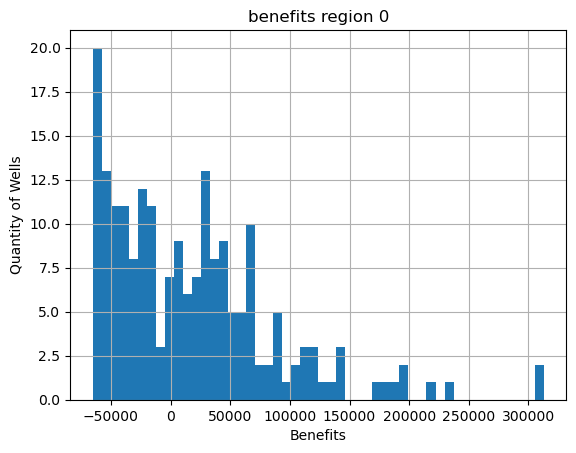

In [38]:
income_reg_0.hist(bins=50)
plt.title('benefits region 0')
plt.ylabel('Quantity of Wells')
plt.xlabel('Benefits')

Podemos observar la distribución de beneficios de la región tomando estas 1000 muestras de 500 pozos tomados al azar de las predicciones y posteriormente eligiendo los 200 mejores pozos de cada muestra, se aprecia que existe una gran cantidad de valores que se concentran en pérdidas por lo que procederemos a calcular los beneficios promedios.

In [39]:
calculos(income_reg_0)

El beneficio promedio de la region es de 17247.3556776895 USD, el intervalo de confianza se encuentra entre -63152.487022795685 y 198284.69929921653 USD, el riesgo en la región es de un 47%


### 8.2. Riesgo y ganancias región 1

In [40]:
pred_reg_1 = pd.Series(predictions_valid_1)

In [41]:
values_1 = []
for i in range(1000):
    subsample = pred_reg_1.sample(n=500, replace=True, random_state=state)
    values_1.append(subsample)

In [42]:
income_reg_1 = income2(values_1)

C:\Users\digom\AppData\Local\Temp\ipykernel_9400\2740434434.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vol_top.append(top_200)


Text(0.5, 0, 'Benefits')

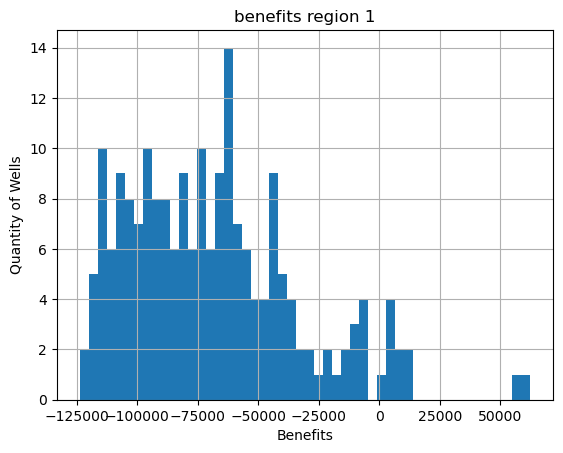

In [43]:
income_reg_1.hist(bins=50)
plt.title('benefits region 1')
plt.ylabel('Quantity of Wells')
plt.xlabel('Benefits')

En el caso de la región 1 podemos apreciar que la mayor parte de la distribución de beneficios se encuentra en un rango de perdida.

In [44]:
calculos(income_reg_1)

El beneficio promedio de la region es de -69331.58354753112 USD, el intervalo de confianza se encuentra entre -117594.11252202511 y 7122.114809576148 USD, el riesgo en la región es de un 94%


### 8.3. Riesgo y ganancias región 2

In [45]:
pred_reg_2 = pd.Series(predictions_valid_2)

In [46]:
values_2 = []
for i in range(1000):
    subsample = pred_reg_2.sample(n=500, replace=True, random_state=state)
    values_2.append(subsample)

In [47]:
income_reg_2 = income2(values_2)

C:\Users\digom\AppData\Local\Temp\ipykernel_9400\2740434434.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vol_top.append(top_200)


Text(0.5, 0, 'Benefits')

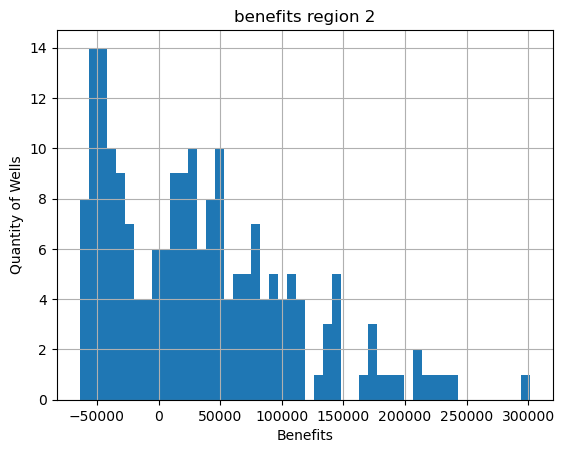

In [48]:
income_reg_2.hist(bins=50)
plt.title('benefits region 2')
plt.ylabel('Quantity of Wells')
plt.xlabel('Benefits')

Parecido al primer caso, podemos observar una distribución de beneficios sesgada hacia la izquierda.

In [49]:
calculos(income_reg_2)

El beneficio promedio de la region es de 33203.37418656224 USD, el intervalo de confianza se encuentra entre -59561.25962090466 y 213446.04723690773 USD, el riesgo en la región es de un 38%


### 8.4. Elección final

Finalmente, al comparar los beneficios y el riesgo de las tres regiones podemos concluir que la peor región para invertir es la región 1 con un 94% de riesgo, es decir es prácticamente seguro que el desarrollo de pozos en la misma no lograra cubrir los costes. Por otra parte, entre las dos regiones restantes la más segura para invertir es la región 2 teniendo un 38% de riesgo versus la región 0 que posee un 47% pero a su vez la región 2 también posee un ingreso promedio mayor, debido a estos dos factores es que se recomienda que se realizen los pozos en la región 2.

## 9. Conclusiones

Comenzamos el proyecto realizando una rápida exploración a las base de datos entregadas por OilyGiant, encontrando valores de "id" duplicados en las tres bases de datos pero al no ser una cantidad relevante, un 0,01% de las filas en el peor de los casos, se mantuvieron. Independiente de lo anterior, no se encontraron problemas en ninguna de las otras columnas de la base de datos.

Se procedió a entrenar la base de datos con una mezcla de los datos de todas las regiones para posteriormente realizar predicciones en cada región individualmente, aquí conseguimos observar que para la región 1 se predecían menores volúmenes de reservas de petróleo que para las regiones 0 y 2, las cuales poseían volúmenes similares.

Continuamos definiendo valores que serían útiles para el cálculo de los beneficios y posteriormente definiendo una función para el cálculo de los mismos.

Finalmente se procedió a utilizar el método de bootstrapping para obtener mil muestras de 500 pozos y posteriormente seleccionar los 200 mejores para evaluar los beneficios, esto según las indicaciones de OilyGiant de como llevan a cabo sus procesos. Al evaluar las tres regiones finalmente la más favorable fue la región 2 al poseer el beneficio promedio más alto de las tres, alrededor de los 33203 dólares, y la menor tasa de riesgo de un 38%, es decir que hay un 38% de probabilidades de obtener perdidas si se realizan los pozos en esta región versus un 47% en la región 0 y un 97% en la región 1. Es por lo anterior que se recomienda a OilyGiant que realice el desarrollo de sus pozos en la región 2, correspondiente a la base de datos data_2.